# Supplementary Material

In [28]:
import sys
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from lmfit import minimize, Parameters
from itertools import product
import multiprocess as mp

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from odeModels import MakeModelFromStr
from fittingUtils import residual, ComputeRSquared, PlotFit, PlotData, LoadFit, \
                            perform_bootstrap, compute_confidenceInterval_prediction, \
                            benchmark_prediction_accuracy, compute_confidenceInterval_parameters

# Format plot
sns.set(style="white",
        rc={'figure.figsize':(12,6), 'xtick.labelsize': 22, 'ytick.labelsize': 22})

In [29]:
# Notebook configurations
runFitting = True
n_bootstraps = 5 # Number of bootstraps used in uncertainty estimation
ci_significanceLevel = 0.95 # Significance level for confidence and prediction intervals
nProcesses = 4 # Number of cores to use for bootstrapping


## Supplementary Figure 1: Growth model for OVCAR4 and growth model parameters

In [2]:
# Data and solver configurations
cellLine = "OVCAR4"
modelList = ["Exponential", "Logistic", "Gompertz", "vonBertalanffy", "GeneralisedLogistic"]
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}

# Parameters to fit
params = Parameters()
params.add('r', value=0.05, min=1e-4, max=2., vary=True)
params.add('v', value=1, min=0, max=5, vary=True)
params.add('K', value=100., min=0, max=100., vary=True)
params.add('N0', value=10, min=0, max=100., vary=False)
params.add('DMax', value=100, vary=False)
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8,
                 'nan_policy':'omit', 'verbose':0}

# Environment
dataDir = "./data/"
modelDir = "./fits/growthModel/"
modelPalette = {"Exponential":sns.xkcd_rgb["grey"], "Logistic":sns.xkcd_rgb["clear blue"], 
                "Gompertz":sns.xkcd_rgb["merlot"], "vonBertalanffy":sns.xkcd_rgb["topaz"],
                "GeneralisedLogistic":sns.xkcd_rgb["mango"]}

In [3]:
# Load off-treatment data
dataDf_all = pd.read_csv("./data/continuousTreatmentDf_cleaned.csv",index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DrugConcentration==0)]

### a) Fit and compare growth models using data from cells grown in untreated conditions

#### Carry out fitting

In [7]:
# Prepare data
trainingData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="lowDensity")]
trainingData = trainingData.groupby(by="Time").mean()
trainingData.reset_index(inplace=True)

if runFitting:
    for modelName in tqdm(modelList):
        # Setup env
        currOutDir = os.path.join(modelDir,cellLine,modelName)
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelName)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        if params['N0'].vary==False: params['N0'].value = trainingData.Confluence.iloc[0]

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingData, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelName
        fitObj.data = trainingData
        fitObj.rSq = ComputeRSquared(fitObj,trainingData)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


#### Estimate uncertainty in parameter estimates and model predictions by parametric bootstrapping

In [8]:
if runFitting:
    # Use multi-threading to speed up computation
    pool = mp.Pool(processes=nProcesses)
    def bootstrapJob(job):
        fitObj, outName = job
        return perform_bootstrap(fitObj, n_bootstraps=n_bootstraps, show_progress=False,
                                    solver_kws=solver_kws, optimiser_kws=optimiser_kws, outName=outName)
    jobList = []
    for modelName in modelList:
        outDir = os.path.join(modelDir,cellLine,modelName)
        fitObj,_ = LoadFit(modelName,fitDir=outDir)
        jobList.append([fitObj,os.path.join(outDir, "bootstraps.csv")])
    # [bootstrapJob(x) for x in jobList]
    list(tqdm(pool.imap(bootstrapJob, jobList), total=len(jobList)));

  0%|          | 0/5 [00:00<?, ?it/s]./utils/odeModels.py:114: RuntimeWarning: invalid value encountered in power
  dudtVec[0] = self.paramDic['r'] * (1 - np.power(N / self.paramDic['K'], self.paramDic['v'])) * N
100%|██████████| 5/5 [08:20<00:00, 100.01s/it]


#### Plot fits

100%|██████████| 5/5 [00:24<00:00,  4.98s/it]


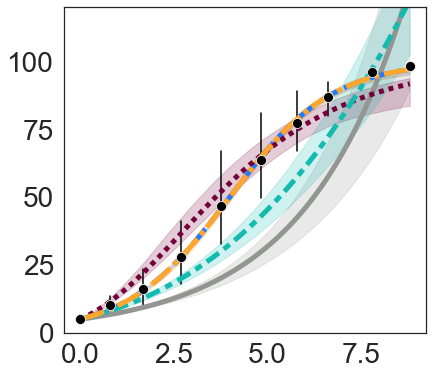

In [9]:
outDir = os.path.join(modelDir,cellLine)
currData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="lowDensity")]
# Load models and simulate
tmpList = []
for modelName in tqdm(modelList):
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir, modelName))
    # Simulate
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    currPredictionDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                             treatmentScheduleList=utils.ExtractTreatmentFromDf(currData),
                                                             show_progress = False, n_time_steps=100,
                                                             alpha=ci_significanceLevel,
                                                             solver_kws=solver_kws, optimiser_kws=optimiser_kws)
    currPredictionDf.rename(columns={"Estimate_MLE":"TumourSize"}, inplace=True)
    currPredictionDf['Model'] = modelName
    currPredictionDf['CellLine'] = cellLine
    tmpList.append(currPredictionDf.copy())
modelFitsDf = pd.concat(tmpList)

# Plot
fig, ax = plt.subplots(1,1,figsize=(6.5,6))
sns.lineplot(x="Time",y="TumourSize", hue="Model", style="Model",
             lw=5,palette=modelPalette,
             legend=False,
             data=modelFitsDf, ax=ax)
for modelName in modelList:
    currPredictionDf = modelFitsDf[modelFitsDf.Model==modelName]
    plt.fill_between(currPredictionDf.Time, currPredictionDf['CI_Lower_Bound'], 
                     currPredictionDf['CI_Upper_Bound'], color=modelPalette[modelName], alpha=0.2)

sns.lineplot(x="Time",y="Confluence",style="CellLine",err_style='bars', #units="ReplicateId", estimator=None,
         markers="o", lw=0, markersize=10, color="black",
         legend=False,
        data=currData,ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,120)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/fits_growthModel_%s.pdf"%cellLine)

#### Plot inferred density-dependence relationship

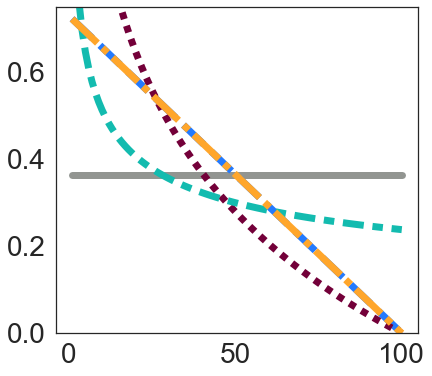

In [10]:
xVec = np.linspace(1,100,100)
# 1. Compute the per-capita growth rate under each model (using the estimated parameters)
outDir = os.path.join(modelDir,cellLine)
tmpDfList = []
for modelName in modelList:
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir, modelName))
    perCapitaGrowthRateList = [myModel.ModelEqns(None,[x,0])[0]/x for x in xVec]
    tmpDf = pd.DataFrame({"Model":modelName, "Density":xVec, 
                          "PerCapitaGrowthRate":perCapitaGrowthRateList})
    tmpDfList.append(tmpDf)
growthRateDf = pd.concat(tmpDfList)

# 2. Plot
fig, ax = plt.subplots(1,1,figsize=(6.5,6))
sns.lineplot(x="Density",y="PerCapitaGrowthRate", hue="Model", style="Model",
                 lw=7,palette=modelPalette,
                 legend=False,
                 data=growthRateDf, ax=ax)
ax.set_ylim(0,0.75)
ax.tick_params(labelsize=28)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/densityDependence_%s.pdf"%cellLine)

#### Quantify goodness-of-fit using AIC

100%|██████████| 5/5 [00:00<00:00, 657.21it/s]


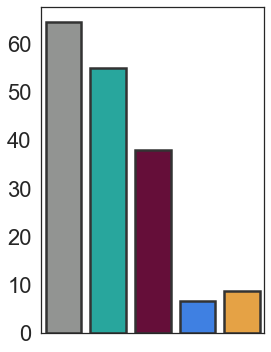

In [11]:
measure = "AIC"
outDir = os.path.join(modelDir,cellLine)
tmpList = []
for modelName in tqdm(modelList):
    fitObj,_ = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))
    tmpList.append({"Model":modelName, "FitId":fitObj.fitId,
                    "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
comparisonDf_gof = pd.DataFrame(tmpList)

# Plot
fig, ax = plt.subplots(1,1,figsize=(4,6))
comparisonDf_gof.sort_values(by=measure,inplace=True)
sns.barplot(x="Model",y=measure,
            edgecolor=".2",linewidth=2.5,
            palette=modelPalette,
            order=["Exponential", "vonBertalanffy", "Gompertz", "Logistic", "GeneralisedLogistic"],
            data=comparisonDf_gof, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
plt.savefig("./figures/%s_fit_%s.pdf"%(measure,cellLine))

In [12]:
comparisonDf_gof.loc[comparisonDf_gof.Model=="Logistic",'AIC'].values - comparisonDf_gof.loc[comparisonDf_gof.Model=="GeneralisedLogistic",'AIC'].values



array([-1.99975938])

### b) Test model by benchmarking its ability to predict growth from higher initial seeding density

#### Generate predictions

In [13]:
# Run predictions
tmpList = []
outDir = os.path.join(modelDir,cellLine)
testingDataDf = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]
testingDataDf = testingDataDf.groupby(by="Time").mean()
testingDataDf.reset_index(inplace=True)

# Load models and simulate
for modelName in tqdm(modelList):
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))

    # Simulate
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    currPredictionDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(testingDataDf),
                                                     initialConditionsList={"N0":testingDataDf.Confluence.iloc[0]},
                                                     show_progress=False, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws)

    currPredictionDf.rename(columns={"Estimate_MLE":"TumourSize"}, inplace=True)
    currPredictionDf['Model'] = modelName
    currPredictionDf['CellLine'] = cellLine
    tmpList.append(currPredictionDf.copy())
modelPredictionDf = pd.concat(tmpList)

100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


#### Plot predictions

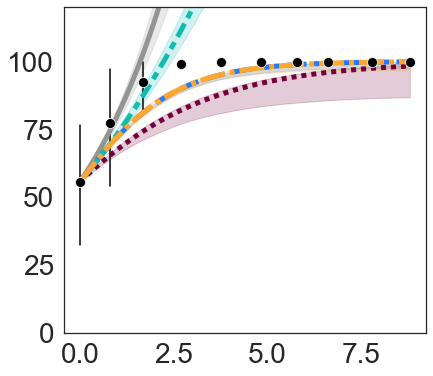

In [14]:
# Plot Predictions
outDir = os.path.join(modelDir,cellLine)
testingData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]

# Plot
fig, ax = plt.subplots(1,1,figsize=(6.5,6))
sns.lineplot(x="Time",y="TumourSize", hue="Model", style="Model",
         lw=5,palette=modelPalette,
         legend=False,
         data=modelPredictionDf[modelPredictionDf.CellLine==cellLine], ax=ax)
for modelName in modelList:
    currPredictionDf = modelPredictionDf[(modelPredictionDf.CellLine==cellLine) & 
                                         (modelPredictionDf.Model==modelName)]
    plt.fill_between(currPredictionDf.Time, currPredictionDf['CI_Lower_Bound'], 
                     currPredictionDf['CI_Upper_Bound'], color=modelPalette[modelName], alpha=0.2)

sns.lineplot(x="Time",y="Confluence",style="CellLine",err_style='bars', #units="ReplicateId", estimator=None,
         markers="o", lw=0, markersize=10, color="black",
         legend=False,
        data=testingData,ax=ax)
ax.set_ylim(0,120)
ax.tick_params(labelsize=28)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/predictions_growthModel_%s.pdf"%cellLine)

#### Quantify goodness-of-fit of the predictions

In [15]:
# Run predictions
tmpList = []
outDir = os.path.join(modelDir,cellLine)
testingDataDf = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]
testingDataDf = testingDataDf.groupby(by="Time").mean()
testingDataDf.reset_index(inplace=True)

# Load models and simulate
for modelName in tqdm(modelList):
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))

    # Simulate
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    currBenchmarkResultsDf = benchmark_prediction_accuracy(fitObj=fitObj, 
                                                           bootstrapResultsDf=bootstrapResultsDf, 
                                                           dataDf=testingDataDf,
                                                           initialConditionsList={"N0":testingDataDf.Confluence.iloc[0]},
                                                           show_progress=False, solver_kws=solver_kws)
    currBenchmarkResultsDf['Model'] = modelName
    currBenchmarkResultsDf['CellLine'] = cellLine
    tmpList.append(currBenchmarkResultsDf.copy())
modelPredictionDf_comp = pd.concat(tmpList)

100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


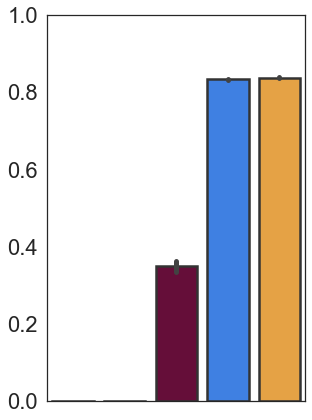

In [16]:
measure = "rSquared"
fig, ax = plt.subplots(1,1,figsize=(4.5,6))
sns.barplot(x="Model", y=measure,
            edgecolor=".2", linewidth=2.5, errwidth=5,
            palette=modelPalette,
            order=["Exponential", "vonBertalanffy", "Gompertz", "Logistic", "GeneralisedLogistic"],
            data=modelPredictionDf_comp[modelPredictionDf_comp.CellLine==cellLine], ax=ax)
ax.set_ylim(0,1)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
plt.tight_layout()
plt.savefig("./figures/predictions_growth_hd_%s.pdf"%(cellLine))

### c) & d) Summary plot and table of parameter estimates for OVCAR3

In [18]:
# Assemble parameter estimates and confidence intervals
tmpList = []
for cellLine, modelName in product(["OVCAR3", "OVCAR4"], modelList):
    outDir = os.path.join(modelDir,cellLine)
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    tmpDf = compute_confidenceInterval_parameters(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf)
    tmpDf['Model'] = modelName
    tmpDf['CellLine'] = cellLine
    tmpList.append(tmpDf)
paramsDf = pd.concat(tmpList)

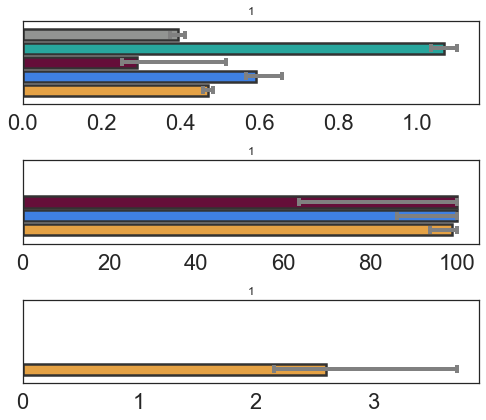

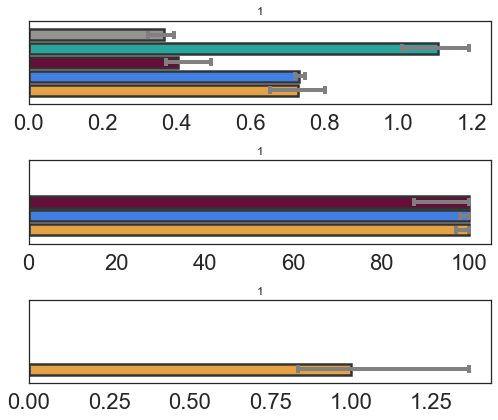

In [19]:
plottingOrder = {"GeneralisedLogistic":0, "Logistic":1, "Gompertz":2, "vonBertalanffy":3, "Exponential":4}
for cellLine in ["OVCAR3", "OVCAR4"]:
    fig, axList = plt.subplots(3,1,figsize=(7,6))
    for i,par in enumerate(['r','K','v']):
        ax = axList[i]
        currDataDf = paramsDf[(paramsDf.CellLine==cellLine) & ((paramsDf.Parameter==par))]
        currDataDf = currDataDf.sort_values(by=['Model'], key=lambda x: x.map(plottingOrder))
        sns.barplot(x="Estimate_MLE",y="Model",
                    edgecolor=".2",linewidth=2.5,
                    palette=modelPalette,
                    data=currDataDf,ax=axList[i])
        # Extract and plot error bars
        ax.errorbar(x=currDataDf["Estimate_MLE"], 
                    y=np.arange(currDataDf.shape[0]),
                    xerr=np.array([currDataDf['Estimate_MLE']-currDataDf['Lower_Bound'],
                                   currDataDf['Upper_Bound']-currDataDf['Estimate_MLE']]), 
                    fmt='none', c='grey', capsize=4, elinewidth=4, capthick=4)
        ax.set_ylim(-1,len(modelList))
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_yticks([])
        ax.set_title("1")
    plt.tight_layout()
    plt.savefig("./figures/params_growthModel_%s.pdf"%cellLine)

In [22]:
paramsDf[paramsDf.CellLine=="OVCAR3"]

,Parameter,Estimate_MLE,Lower_Bound,Upper_Bound,Model,CellLine
0,r,0.393974,0.374693,0.411449,Exponential,OVCAR3
0,r,0.592279,0.565108,0.656552,Logistic,OVCAR3
1,K,100.000000,86.029514,100.000000,Logistic,OVCAR3
0,r,0.291365,0.252957,0.516162,Gompertz,OVCAR3
1,K,100.000000,63.578473,100.000000,Gompertz,OVCAR3
0,r,1.068020,1.034863,1.101996,vonBertalanffy,OVCAR3
0,r,0.468891,0.456555,0.481810,GeneralisedLogistic,OVCAR3
1,K,98.755814,93.768203,100.000000,GeneralisedLogistic,OVCAR3
2,v,2.603333,2.157254,3.725653,GeneralisedLogistic,OVCAR3


In [23]:
paramsDf[paramsDf.CellLine=="OVCAR4"]

,Parameter,Estimate_MLE,Lower_Bound,Upper_Bound,Model,CellLine
0,r,0.365024,0.324241,0.394342,Exponential,OVCAR4
0,r,0.730627,0.720084,0.748529,Logistic,OVCAR4
1,K,100.000000,97.806031,100.000000,Logistic,OVCAR4
0,r,0.403343,0.370502,0.492900,Gompertz,OVCAR4
1,K,100.000000,87.410524,100.000000,Gompertz,OVCAR4
0,r,1.106461,1.009066,1.192635,vonBertalanffy,OVCAR4
0,r,0.730168,0.653235,0.802894,GeneralisedLogistic,OVCAR4
1,K,100.000000,96.859426,100.000000,GeneralisedLogistic,OVCAR4
2,v,1.001323,0.835176,1.367853,GeneralisedLogistic,OVCAR4


## Multi-step Model

In [4]:
# Data and solver configurations
cellLine = "OVCAR3"
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8,
                 'nan_policy':'omit', 'verbose':2}

# Load growth model parameters
modelName = "CycleArrestModel_multiStep"
nStepsList = np.arange(1,5) # Which parameter values for n_steps to examine
subModelsList = ["equalParams", "varying_r", "varying_r_decreasing", "varying_alpha", "2phase"] # Sub-models (e.g. allowing alpha to change as damage accumulates)
growthModel = "GeneralisedLogistic"
fitObj,_ = LoadFit(growthModel,fitDir=os.path.join("./fits/growthModel/%s"%cellLine,growthModel))
params_growth = fitObj.params
params_growth['r'].set(vary=False)
params_growth['K'].set(vary=False)
params_growth['v'].set(vary=False)
params_growth['N0'].set(vary=False)
growthModelBootstrapsDf = pd.read_csv(os.path.join("./fits/growthModel/%s"%cellLine, growthModel, "bootstraps.csv"), index_col=0)

# Parameters for the multi-step model
params = params_growth.copy()
params.add('alpha', value=0.75, min=0, max=1, vary=True)
params.add('beta', value=0.1, min=0, max=5e-1, vary=True)
params.add('gamma', value=0.1, min=0, max=4, vary=True)
params.add('d_A', value=5e-2, min=0, max=4, vary=True)
params.add('n_steps', value=2, min=1, max=5, vary=False)
# Assume that all accumulating damage does not alter the proliferation rate (r) or sensitivity to drug (alpha)
for x in range(params['n_steps'].max):
    params.add('r%d'%x, value=params['r'].value, min=params['r'].min, max=params['r'].max, vary=False)
for x in range(params['n_steps'].max):
    params.add('alpha%d'%x, value=params['alpha'].value, min=params['alpha'].min, max=params['alpha'].max, vary=False)
# Assume that initially all cells are in the P compartment
for x in range(params['n_steps'].max):
    params.add('P%d0'%x, value=0, vary=False)
params.add('A0', value=0, vary=False)

# Environment
dataDir = "./data/"
modelDir = "./fits/"
multiStepPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
                    "P0":'#00882B',
                    "P1":'#5C886A',
                    "P2":'#5C796A',
                    "P3":'#5C6E6A',
                    "P4":'#5C626A',
                    "A":'#773F9B'}
nStepsPalette = sns.cubehelix_palette(5, start=.5, rot=-.5)

In [5]:
# Load the treatment data for model development and testing
dataDf_all = pd.read_csv("./data/intermittentTreatmentDf_cleaned.csv", index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DMax==100) & (dataDf_all.CellLine==cellLine)] # Only select 100uM experiment here. Will use 50uM when developing the dose-resoponse model

# For model development, use the data for CT treatment
trainingDataDf_all = dataDf_all[dataDf_all.Delay==100]
trainingDataDf_avg = trainingDataDf_all.groupby(by="Time").mean().reset_index()

# For model testing, use the data from the 7d-on experiment
testingDataDf_all = dataDf_all[dataDf_all.Delay==7]
testingDataDf_avg = testingDataDf_all.groupby(by="Time").mean().reset_index()

### Fit for different assumptions about which parameters are (or are not) allowed to change as damage accumulates

#### Equal parameters across all populations

In [5]:
# Setup environment
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName+"_equalParams")

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelName, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Assume r and alpha are the same across all populations
        currParams.add(params['r'])        
        currParams.add(params['alpha'])
        for x in range(n_steps):
            currParams['r%d'%x].set(expr='r', vary=False)
            currParams['alpha%d'%x].set(expr='alpha', vary=False)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelName
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3992e+03                                    5.77e+03    
       1              2         8.2415e+02      5.75e+02       1.42e-01       3.73e+03    
       2              3         7.2460e+02      9.96e+01       2.14e-02       1.55e+03    
       3              5         6.9631e+02      2.83e+01       8.11e-02       2.50e+04    
       4              6         6.1697e+02      7.93e+01       3.28e-02       1.01e+03    
       5              8         6.1207e+02      4.90e+00       9.09e-03       2.38e+02    
       6              9         6.0580e+02      6.26e+00       1.28e-02       9.38e+02    
       7             11         6.0292e+02      2.88e+00       7.78e-03       2.64e+01    
       8             12         5.9764e+02      5.28e+00       1.22e-03       9.56e+00    
       9             13         5.9437e+02      3.27e+00       1.27e-02       1.11e+03    

#### Varying growth rates as damage is accumulated

In [6]:
# Setup environment
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName+"_varying_r")

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelName, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Allow r to change once the cell has been hit
        currParams.add(params['r'])
        currParams.add(params['alpha'])
        currParams['r0'].set(expr='r', vary=False) # growth rate of proliferating population is fixed as it was determined from the control experiments
        currParams['alpha0'].set(expr='alpha', vary=False) # assume alpha doesn't change as damage accumulates. Need this extra line as for loop in next line starts at n_steps=1.
        for x in range(1, n_steps):
            currParams['r%d'%x].set(vary=True) # No constraints on r
            currParams['alpha%d'%x].set(expr='alpha', vary=False)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelName
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3992e+03                                    5.77e+03    
       1              2         8.2415e+02      5.75e+02       1.42e-01       3.73e+03    
       2              3         7.2460e+02      9.96e+01       2.14e-02       1.55e+03    
       3              5         6.9631e+02      2.83e+01       8.11e-02       2.50e+04    
       4              6         6.1697e+02      7.93e+01       3.28e-02       1.01e+03    
       5              8         6.1207e+02      4.90e+00       9.09e-03       2.38e+02    
       6              9         6.0580e+02      6.26e+00       1.28e-02       9.38e+02    
       7             11         6.0292e+02      2.88e+00       7.78e-03       2.64e+01    
       8             12         5.9764e+02      5.28e+00       1.22e-03       9.56e+00    
       9             13         5.9437e+02      3.27e+00       1.27e-02       1.11e+03    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9084e+04                                    9.21e+03    
       1              2         1.5899e+04      1.32e+04       2.88e+00       3.98e+04    
       2              3         1.0047e+03      1.49e+04       6.70e-01       1.16e+04    
       3              4         2.2131e+02      7.83e+02       3.00e-01       6.91e+03    
       4              5         7.9068e+01      1.42e+02       1.96e-01       1.47e+03    
       5              6         6.5487e+01      1.36e+01       8.45e-02       3.13e+02    
       6              7         6.3657e+01      1.83e+00       2.00e-01       3.31e+02    
       7              8         6.2893e+01      7.64e-01       1.86e-01       4.54e+02    
       8              9         6.2417e+01      4.76e-01       8.42e-02       2.76e+01    
       9             12         6.2189e+01      2.28e-01       1.07e-01       6.16e+01    

#### Varying growth rates as damage is accumulated

In [7]:
# Setup environment
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName+"_varying_r_decreasing")

# Refine solver_kws for fitting
solver_kws_fitting = solver_kws.copy()
solver_kws_fitting['max_step'] = 0.5

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelName, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Allow r to change once the cell has been hit
        currParams.add(params['r'])
        currParams.add(params['alpha'])
        currParams['r0'].set(expr='r', vary=False) # growth rate of proliferating population is fixed as it was determined from the control experiments
        currParams['alpha0'].set(expr='alpha', vary=False) # assume alpha doesn't change as damage accumulates. Need this extra line as for loop in next line starts at n_steps=1.
        for x in range(1, n_steps):
            # Assume growth rate decreases as damage is accumulated
            currParams.add('f%d'%x,value=1,min=0,max=1,vary=True)
            currParams['r%d'%x].set(expr='f%d*r%d'%(x,x-1),vary=False)
            currParams['alpha%d'%x].set(expr='alpha', vary=False)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws_fitting),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelName
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3992e+03                                    5.77e+03    
       1              2         8.2415e+02      5.75e+02       1.42e-01       3.73e+03    
       2              3         7.2459e+02      9.96e+01       2.14e-02       1.55e+03    
       3              5         6.9632e+02      2.83e+01       8.11e-02       2.50e+04    
       4              6         6.1697e+02      7.93e+01       3.28e-02       1.01e+03    
       5              8         6.1207e+02      4.90e+00       9.09e-03       2.38e+02    
       6              9         6.0580e+02      6.26e+00       1.28e-02       9.38e+02    
       7             11         6.0292e+02      2.88e+00       7.78e-03       2.64e+01    
       8             12         5.9764e+02      5.28e+00       1.22e-03       9.56e+00    
       9             13         5.9437e+02      3.27e+00       1.27e-02       1.11e+03    

#### Varying kill rates as damage is accumulated

In [8]:
# Setup environment
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName+"_varying_alpha")

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelName, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Allow r to change once the cell has been hit
        currParams.add(params['r'])
        currParams['r0'].set(expr='r', vary=False) # growth rate of proliferating population is fixed as it was determined from the control experiments
        currParams['alpha0'].set(vary=True) # Need this extra line as for loop in next line starts at n_steps=1.
        for x in range(1, n_steps):
            currParams['r%d'%x].set(expr='r', vary=False)
            currParams['alpha%d'%x].set(vary=True)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelName
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3992e+03                                    5.77e+03    
       1              2         8.2415e+02      5.75e+02       1.42e-01       3.73e+03    
       2              3         7.2460e+02      9.96e+01       2.14e-02       1.55e+03    
       3              5         6.9631e+02      2.83e+01       8.11e-02       2.50e+04    
       4              6         6.1697e+02      7.93e+01       3.28e-02       1.01e+03    
       5              8         6.1207e+02      4.90e+00       9.09e-03       2.38e+02    
       6              9         6.0580e+02      6.26e+00       1.28e-02       9.38e+02    
       7             11         6.0292e+02      2.88e+00       7.78e-03       2.64e+01    
       8             12         5.9764e+02      5.28e+00       1.22e-03       9.56e+00    
       9             13         5.9437e+02      3.27e+00       1.27e-02       1.11e+03    

      15             20         7.6250e+01      3.68e-08       3.36e-05       5.59e-04    
`ftol` termination condition is satisfied.
Function evaluations 20, initial cost 2.7183e+04, final cost 7.6250e+01, first-order optimality 5.59e-04.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9084e+04                                    9.21e+03    
       1              2         2.3529e+04      5.55e+03       2.92e+00       4.21e+03    
       2              3         2.6654e+03      2.09e+04       7.97e-01       5.63e+02    
       3              4         1.9415e+03      7.24e+02       1.49e-01       1.74e+02    
       4              5         1.6713e+03      2.70e+02       7.86e-02       5.27e+01    
       5              6         1.5763e+03      9.50e+01       2.98e-02       1.42e+01    
       6              7         1.5499e+03      2.64e+01       6.52e-03       2.31e+00    
       7              8         

### Fit model which assumes that cells eventually become apoptotic independent of proliferation

In [8]:
# Setup environment
modelName = "CycleArrestModel_multiStep_2phase"
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName)

if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelName, n_steps=n_steps)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        # Assume r and alpha are the same across all populations
        currParams.add(params['r'])        
        currParams.add(params['alpha'])
        currParams['beta'].set(value=0, vary=False)
        for x in range(n_steps):
            currParams['r%d'%x].set(expr='r', vary=False)
            currParams['alpha%d'%x].set(expr='alpha', vary=False)
        currParams['r%d'%(x+1)].set(expr='r', vary=False)
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelName
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))
modelName = "CycleArrestModel_multiStep"

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6667e+04                                    1.45e+05    
       1              2         1.3313e+03      2.53e+04       8.64e-01       7.55e+03    
       2              3         1.4613e+02      1.19e+03       1.36e-01       4.60e+03    
       3              4         1.2669e+02      1.94e+01       3.72e-01       1.20e+04    
       4              5         8.0367e+01      4.63e+01       2.67e-01       1.88e+03    
       5              6         7.5972e+01      4.39e+00       2.62e-01       1.18e+03    
       6              7         7.5087e+01      8.86e-01       1.45e-01       2.71e+02    
       7              8         7.5042e+01      4.43e-02       5.60e-02       1.59e+02    
       8             10         7.5026e+01      1.65e-02       9.34e-03       1.48e+02    
       9             12         7.5018e+01      7.44e-03       2.39e-03       7.75e+00    

### Perform uncertainty estimation

In [10]:
if runFitting:
    # Use multi-threading to speed up computation
    pool = mp.Pool(processes=nProcesses)
    def bootstrapJob(job):
        fitObj, n_steps, outName = job
        # Turn off verboseness for bootstrapping
        optimiser_kws_bootstrapping = optimiser_kws.copy()
        optimiser_kws_bootstrapping['verbose'] = 0
        # Refine solver_kws for bootstrapping
        solver_kws_bootstrapping = solver_kws.copy()
        solver_kws_bootstrapping['max_step'] = 0.25
#         solver_kws_bootstrapping['method'] = "BDF"
        if os.path.exists(outName): 
            print(outName)
            print(fitObj.modelName, n_steps, " -- Done")
            return 0
        return perform_bootstrap(fitObj=fitObj,
                          prior_experiment_df=growthModelBootstrapsDf,
                          model_kws={"n_steps":n_steps},
                          n_bootstraps=n_bootstraps, show_progress=False,
                          solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws_bootstrapping, 
                          outName=outName)    
    jobList = []
    for fittingType, n_steps in product(subModelsList,nStepsList):
        if fittingType=="2phase":
            modelName = "CycleArrestModel_multiStep_2phase"
            outDir = os.path.join(modelDir, "treatmentModel", cellLine, 
                      modelName, "n_steps_%d"%(n_steps))
        else:
            modelName = "CycleArrestModel_multiStep"
            outDir = os.path.join(modelDir, "treatmentModel", cellLine, 
                                  modelName+"_"+fittingType, "n_steps_%d"%(n_steps))
        fitObj,_ = LoadFit(modelName,fitDir=outDir)
        jobList.append([fitObj,n_steps,os.path.join(outDir, "bootstraps.csv")])
#     [bootstrapJob(x) for x in jobList]
    list(tqdm(pool.imap(bootstrapJob, jobList), total=len(jobList)));

  0%|          | 0/20 [00:00<?, ?it/s]

./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_equalParams/n_steps_1/bootstraps.csv
CycleArrestModel_multiStep

 50%|█████     | 10/20 [00:00<00:00, 93.45it/s]

 1  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_equalParams/n_steps_2/bootstraps.csv
CycleArrestModel_multiStep 2  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_equalParams/n_steps_3/bootstraps.csv
CycleArrestModel_multiStep 3  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_equalParams/n_steps_4/bootstraps.csv
CycleArrestModel_multiStep 4  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_varying_r/n_steps_1/bootstraps.csv
CycleArrestModel_multiStep 1  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_varying_r/n_steps_2/bootstraps.csv
CycleArrestModel_multiStep 2  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_varying_r/n_steps_3/bootstraps.csv
CycleArrestModel_multiStep 3

100%|██████████| 20/20 [00:00<00:00, 68.81it/s]

100%|██████████| 20/20 [00:00<00:00, 71.49it/s]

 -- Done


./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_varying_r/n_steps_4/bootstraps.csv
CycleArrestModel_multiStep 4  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_varying_r_decreasing/n_steps_1/bootstraps.csv
CycleArrestModel_multiStep 1  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_varying_r_decreasing/n_steps_2/bootstraps.csv
CycleArrestModel_multiStep 2  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_varying_r_decreasing/n_steps_3/bootstraps.csv
CycleArrestModel_multiStep 3  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_varying_r_decreasing/n_steps_4/bootstraps.csv
CycleArrestModel_multiStep 4  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_varying_alpha/n_steps_1/bootstraps.csv
CycleArrestModel_multiStep 1  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel_multiStep_varying_alpha/n_steps_2/bootstraps.csv
CycleArrestModel_multiStep 2  -- Done
./fits/treatmentModel/OVCAR3/CycleArrestModel

### Plot Fits

In [13]:
# Refine solver_kws for fitting
solver_kws_fitting = solver_kws.copy()
solver_kws_fitting['max_step'] = 0.5

# Load models and simulate
tmpDfList = []
for fittingType, n_steps in product(subModelsList,nStepsList):
    if fittingType=="2phase":
        modelName = "CycleArrestModel_multiStep_2phase"
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, 
                  modelName, "n_steps_%d"%(n_steps))
    else:
        modelName = "CycleArrestModel_multiStep"
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, 
                              modelName+"_"+fittingType, "n_steps_%d"%(n_steps))    
    fitObj,_ = LoadFit(modelName,fitDir=currOutDir)
    bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
    modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx
                                                         treatmentScheduleList=utils.ExtractTreatmentFromDf(trainingDataDf_avg),
                                                         model_kws={"n_steps":n_steps},
                                                         show_progress=True, n_time_steps=100,
                                                         alpha=ci_significanceLevel,
                                                         solver_kws=solver_kws_fitting)
    modelFitsDf['FittingType'] = fittingType
    modelFitsDf['n_steps'] = n_steps
    tmpDfList.append(modelFitsDf)
modelFitsDf = pd.concat(tmpDfList)

100%|██████████| 5/5 [00:00<00:00, 30.62it/s]


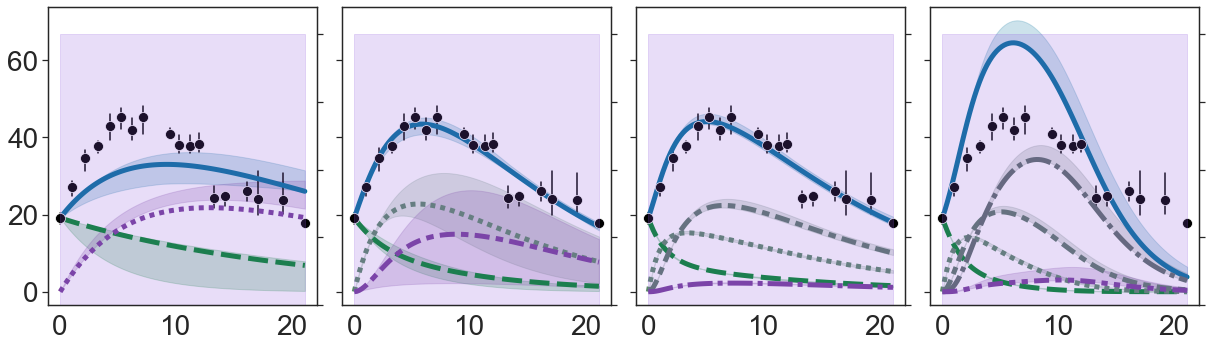

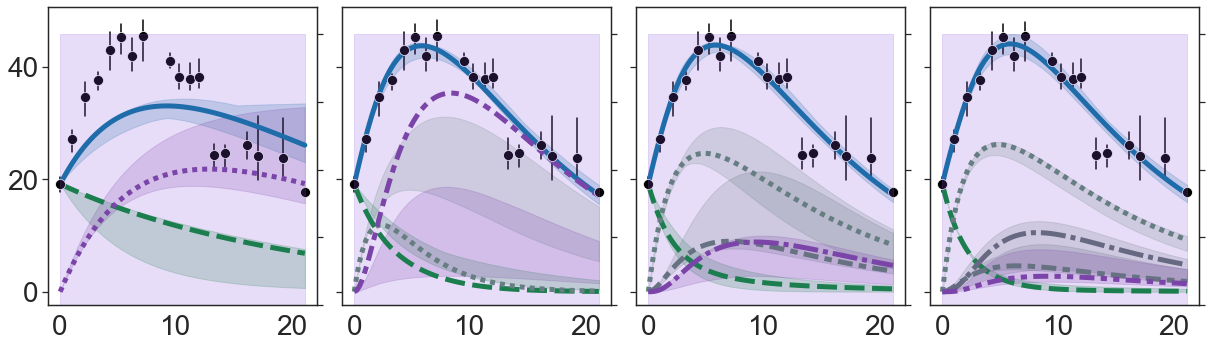

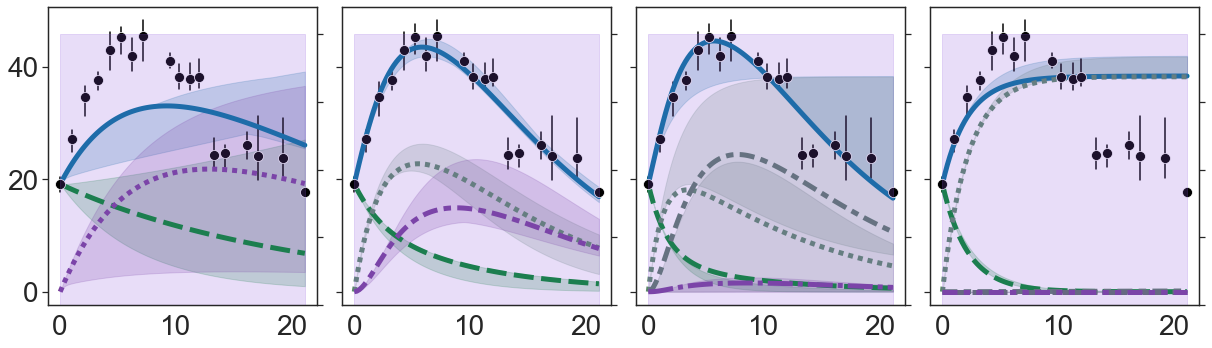

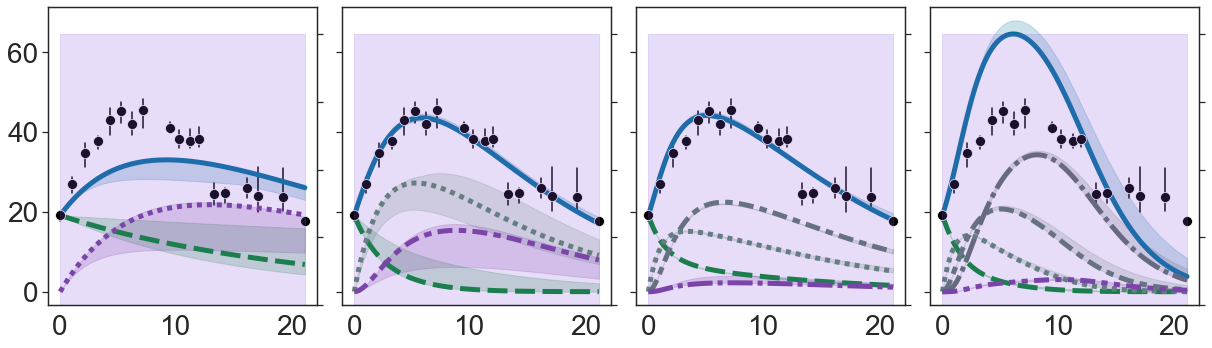

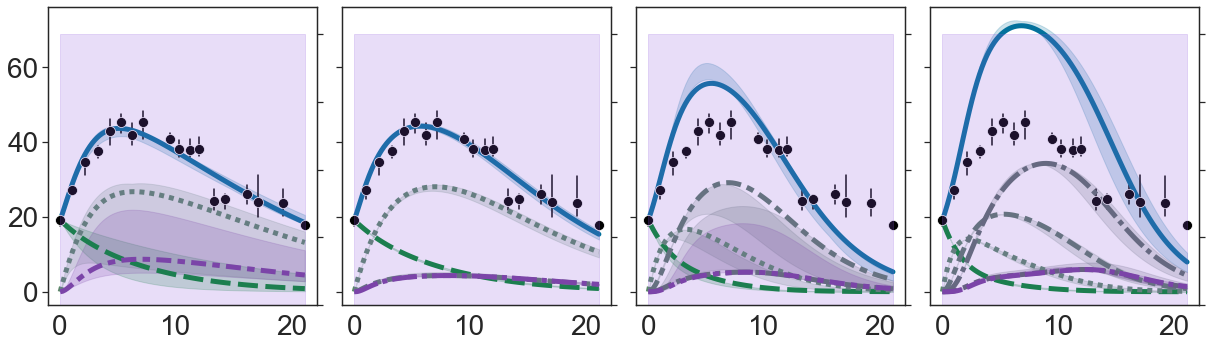

In [14]:
for fittingType in subModelsList:
    fig, axList = plt.subplots(1,len(nStepsList),sharex=True,sharey=True,figsize=(17,5))
    for i, n_steps in enumerate(nStepsList):
        currModelFitsDf = modelFitsDf[(modelFitsDf.FittingType==fittingType) & (modelFitsDf.n_steps==n_steps)]
        # 1. Plot the model predictions and associated confidence intervals
        ax = axList.flatten()[i]
        sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                     lw=5, palette=multiStepPalette,
    #                  style_order=["TumourSize","P0","A","P1"],
                     legend=False,
                     data=currModelFitsDf, ax=ax)
        for var in multiStepPalette.keys():
            currDataDf = currModelFitsDf[currModelFitsDf.Variable==var]
            ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                             currDataDf['CI_Upper_Bound'], color=multiStepPalette[var], alpha=0.2)
        # 2. Plot the data
        sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
                 markers="o", lw=0, markersize=10, color="black",
                 legend=False, data=trainingDataDf_all, ax=ax)
        # 3. Plot the drug concentration
        tmpDf = trainingDataDf_avg.copy()
        tmpDf.Confluence = np.nan
        PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
        ax.tick_params(labelsize=28)
        ax.set_xlabel("")
        ax.set_ylabel("")
        # ax.set_ylim(0,25)
        plt.tight_layout()
    #     plt.savefig("./figures/fits_different_n_steps_%s.pdf"%(cellLine))

## Compare treatment models

In [15]:
treatmentModelsList = ["singleStep", "multiStep_equalParams", 
                       "multiStep_varying_r", "multiStep_varying_r_decreasing", "multiStep_varying_alpha", 
                       "multiStep_2phase", "singleStep_extraDivs"]
def modelMap(name):
    if name=="singleStep": modelName = "CycleArrestModel_singleStep"
    elif name=="multistep_2phase": modelName = "CycleArrestModel_multistep_2phase"
    else: modelName = "CycleArrestModel_multiStep"

In [ ]:
# To do:
# - Plot parameters for each of the different models
# - Compare model fits by AIC
# - Compare predictions for delay data
# - Check that fractional model gives us better/more convincing tumour composition plots

### Plot parameters

In [17]:
# 
# modelNameDic = {""}

# Assemble parameter estimates and confidence intervals
tmpList = []
for fittingType, n_steps in product(subModelsList,nStepsList):
    modelName = "CycleArrestModel_multiStep" if fittingType!="2phase" else "CycleArrestModel_multistep_2phase"
    currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, 
                          modelName+"_"+fittingType, "n_steps_%d"%(n_steps))
    fitObj,_ = LoadFit(modelName,fitDir=currOutDir)
    bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
    tmpDf = compute_confidenceInterval_parameters(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps]) #xxx
    tmpDf['FittingType'] = fittingType
    tmpDf['n_steps'] = n_steps
    tmpList.append(tmpDf)
paramsDf = pd.concat(tmpList)

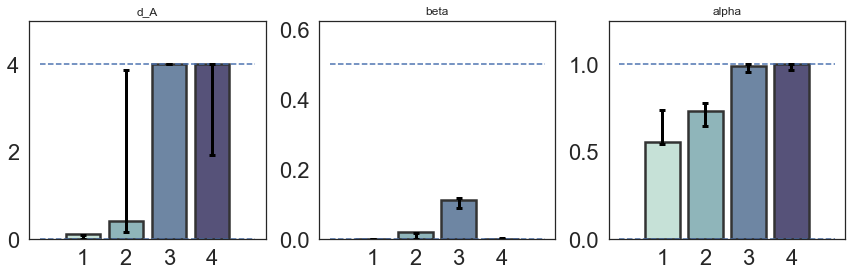

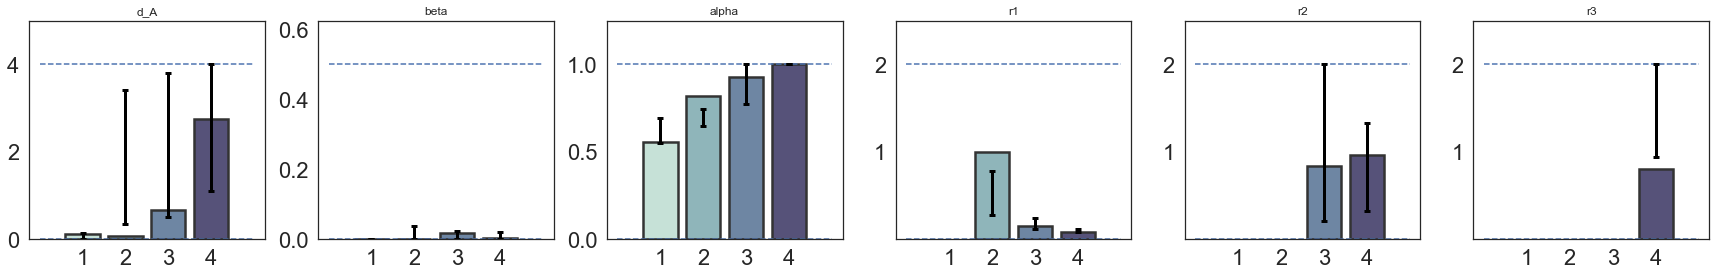

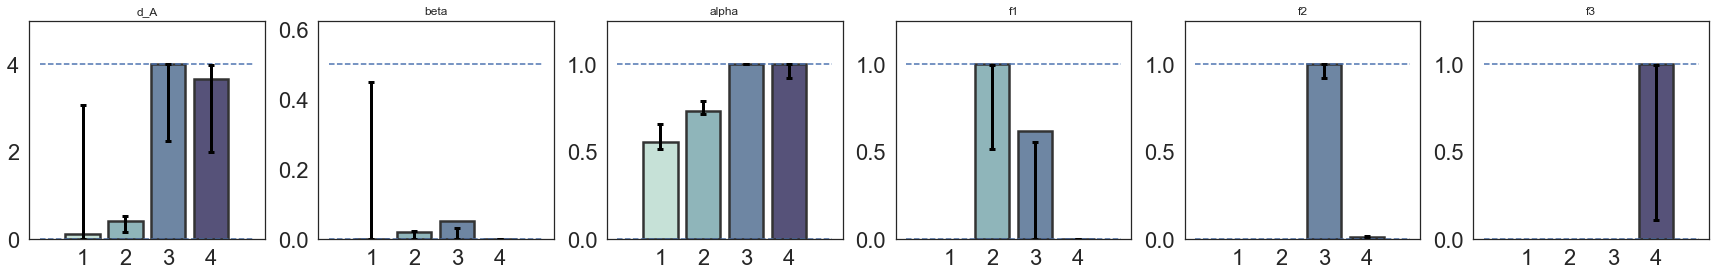

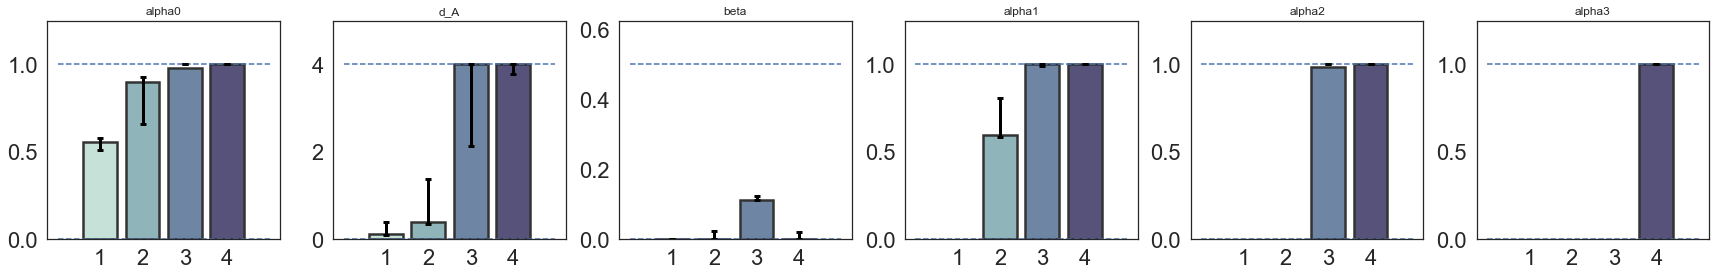

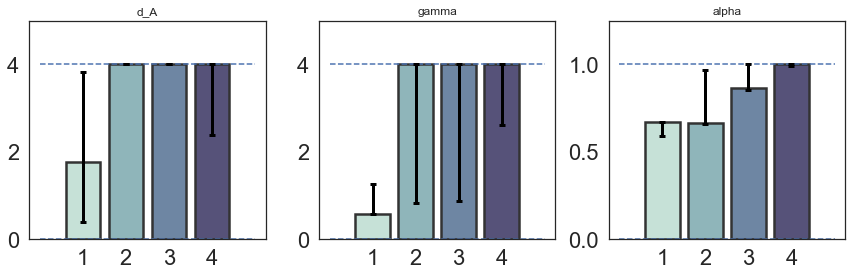

In [18]:
for fittingType in subModelsList:
    paramList = paramsDf[paramsDf.FittingType==fittingType].Parameter.unique()
    fig, axList = plt.subplots(1,len(paramList),sharey=False,figsize=(len(paramList)*4,4))
    for i,par in enumerate(paramList): #['alpha', 'd_A', 'beta']):
        # Format data frame for current parameter. Add empty rows where a model doesn't have a certain
        # parameter so that all the plots use the same x-axis and colour scheme.
        currDataDf = paramsDf[(paramsDf.FittingType==fittingType) & ((paramsDf.Parameter==par))]
        for n_steps in nStepsList:
            if not np.isin(n_steps,currDataDf.n_steps.unique()):
                currDataDf = pd.concat([currDataDf, pd.DataFrame([{'Parameter':par, 'Estimate_MLE':np.nan,
                                                      'Lower_Bound':np.nan, 'Upper_Bound':np.nan,
                                                      'FittingType':fittingType, 'n_steps':n_steps}])])
        currDataDf = currDataDf.sort_values(by="n_steps")
        ax = axList.flatten()[i]
        sns.barplot(x="n_steps",y="Estimate_MLE",
                    edgecolor=".2",linewidth=2.5,
                    palette=nStepsPalette,
                    data=currDataDf,ax=axList[i])
        # Extract and plot error bars
        ax.errorbar(x=np.arange(currDataDf.shape[0]), 
                    y=currDataDf["Estimate_MLE"],
                    yerr=np.array([currDataDf['Estimate_MLE']-currDataDf['Lower_Bound'],
                                   currDataDf['Upper_Bound']-currDataDf['Estimate_MLE']]), 
                    fmt='none', c='black', capsize=3, elinewidth=3, capthick=3)
        # Plot horizontal lines to mark upper and lower bounds
        modelName = "CycleArrestModel_multiStep" if fittingType!="2phase" else "CycleArrestModel_multistep_2phase"
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, 
                      modelName+"_"+fittingType, "n_steps_%d"%(n_steps))
        exampleFit,_ = LoadFit(modelName,fitDir=currOutDir)
        ax.hlines(xmin=-1, xmax=nStepsList.max(), y=exampleFit.params[par].min, linestyles='--')
        ax.hlines(xmin=-1, xmax=nStepsList.max(), y=exampleFit.params[par].max, linestyles='--')
        ax.set_xlabel("")
        ax.set_ylim(0.75*exampleFit.params[par].min, 1.25*exampleFit.params[par].max)
        ax.set_ylabel("")
        ax.set_title(par)
    plt.tight_layout()
#     plt.savefig("./figures/params_growthModel_%s.pdf"%cellLine)

### Compare AIC of fits across models

In [19]:
# Assemble goodness-of-fit quantifications
tmpList_total = []
for fittingType in subModelsList:
    tmpList_subModel = []
    for n_steps in nStepsList:
        modelName = "CycleArrestModel_multiStep" if fittingType!="2phase" else "CycleArrestModel_multistep_2phase"
        currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, 
                              modelName+"_"+fittingType, "n_steps_%d"%(n_steps))
        fitObj,_ = LoadFit(modelName,fitDir=currOutDir)
        tmpList_subModel.append({"FittingType":fittingType, "n_steps":n_steps,
                        "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
    tmpDf = pd.DataFrame(tmpList_subModel)
    tmpList_total.append(tmpDf.loc[tmpDf.AIC.idxmin()])
benchmarkingDf_fitting = pd.DataFrame(tmpList_total)

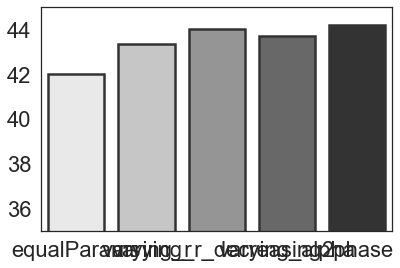

In [21]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.barplot(x="FittingType",y="AIC",
            edgecolor=".2", linewidth=2.5,
            palette="Greys",
            data=benchmarkingDf_fitting, ax=ax)
# ax.tick_params(labelsize=42)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(35,45)
# ax.set_xticks([])
plt.tight_layout()
# plt.savefig("./figures/%s_different_n_steps_equalParams_%s.pdf"%(measure,cellLine))

### Plot predictions for intermittent data

In [23]:
# Load models and simulate
tmpDfList = []
for _, (fittingType, n_steps) in benchmarkingDf_fitting[['FittingType', 'n_steps']].iterrows():
    modelName = "CycleArrestModel_multiStep" if fittingType!="2phase" else "CycleArrestModel_multistep_2phase"
    currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, 
                          modelName+"_"+fittingType, "n_steps_%d"%(n_steps))
    fitObj,_ = LoadFit(modelName,fitDir=currOutDir)
    bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
    for delay in [1,2,4,7]:
        currTestingDataDf = dataDf_all[dataDf_all.Delay==delay].groupby(by="Time").mean().reset_index()
        # Refine solver_kws for prediction
        solver_kws_prediction = solver_kws.copy()
        solver_kws_prediction['max_step'] = 0.5
        modelPredictionsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx
                                                             treatmentScheduleList=utils.ExtractTreatmentFromDf(currTestingDataDf),
                                                             model_kws={"n_steps":n_steps},
                                                             initialConditionsList={"P00":currTestingDataDf.Confluence.iloc[0], "P10":0, "A0":0},
                                                             show_progress=True, n_time_steps=100,
                                                             alpha=ci_significanceLevel,
                                                             solver_kws=solver_kws_prediction)
        modelPredictionsDf['FittingType'] = fittingType
        modelPredictionsDf['n_steps'] = n_steps
        modelPredictionsDf['Delay'] = delay
        tmpDfList.append(modelPredictionsDf)
modelPredictionsDf = pd.concat(tmpDfList)

100%|██████████| 5/5 [00:00<00:00, 25.40it/s]


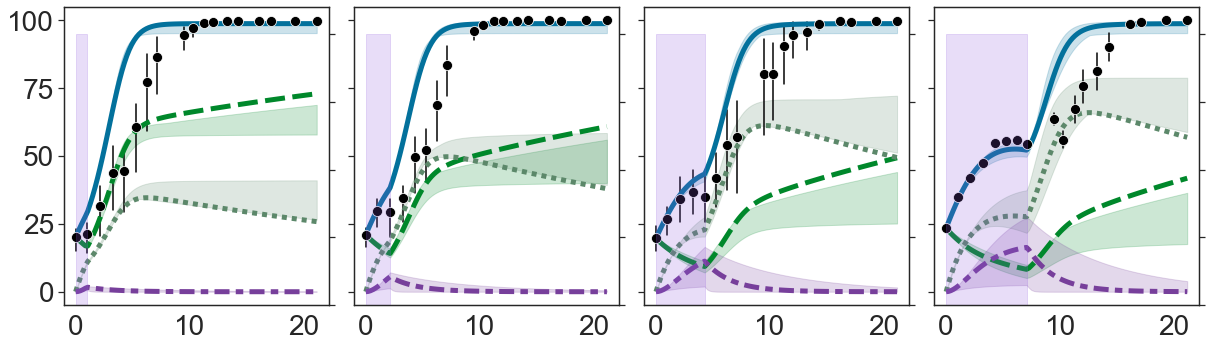

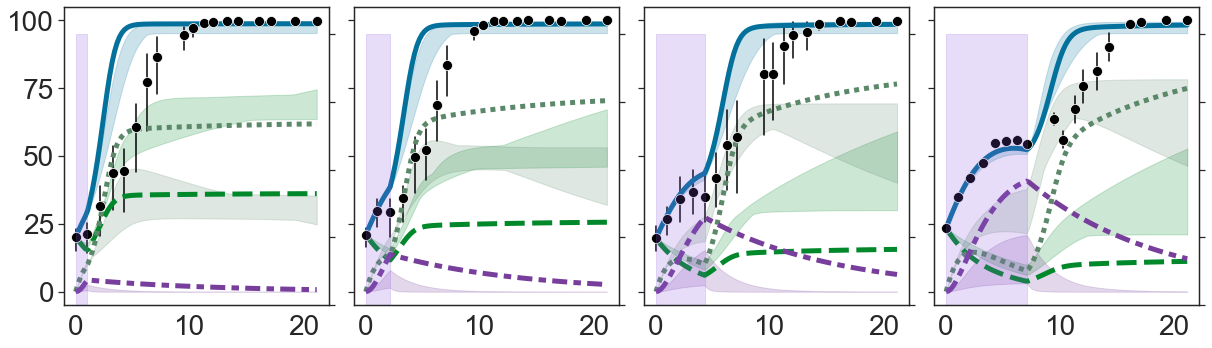

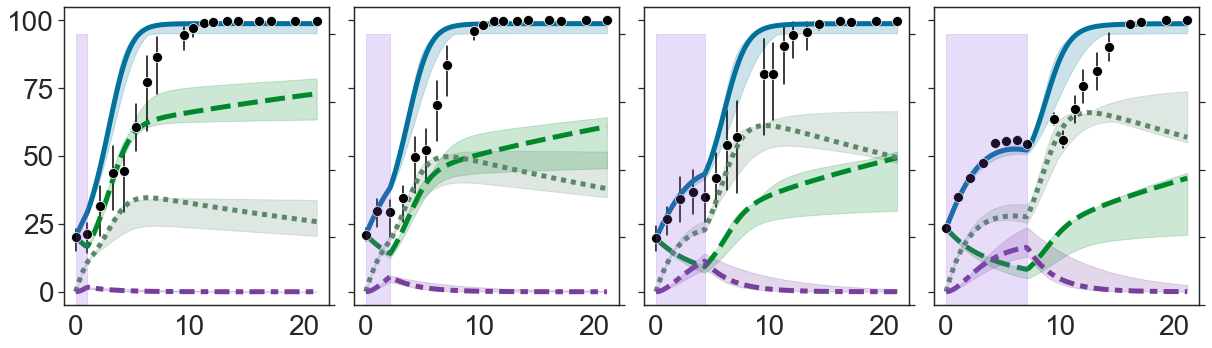

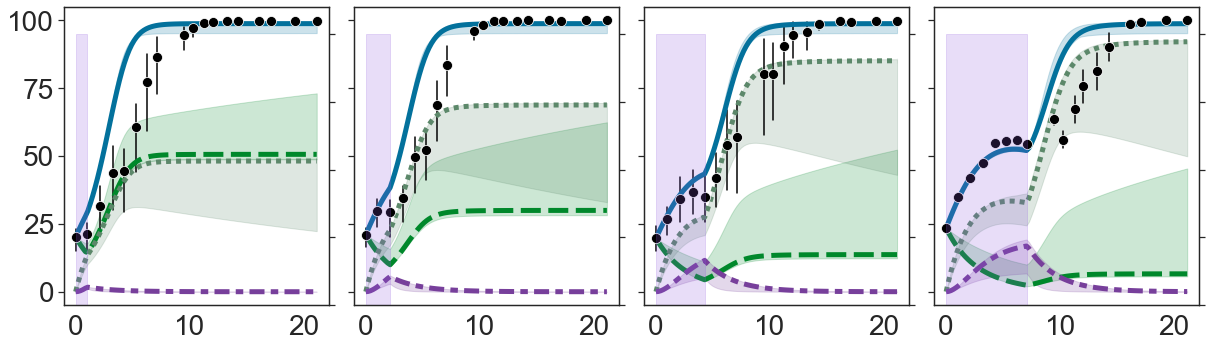

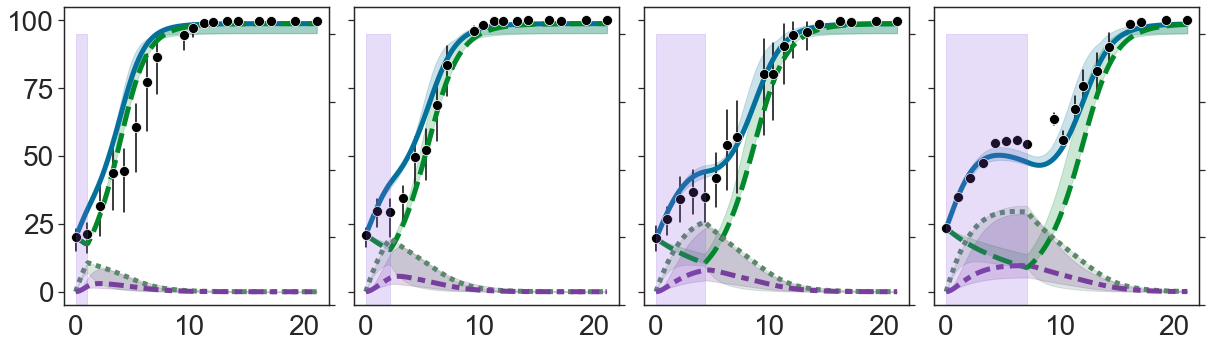

In [24]:
delayList = modelPredictionsDf.Delay.unique()
for _, (fittingType, n_steps) in benchmarkingDf_fitting[['FittingType', 'n_steps']].iterrows():
    fig, axList = plt.subplots(1,len(delayList),sharex=True,sharey=True,figsize=(17,5))
    for i,delay in enumerate(delayList):
        currmodelPredictionsDf = modelPredictionsDf[(modelPredictionsDf.FittingType==fittingType) &
                                                    (modelPredictionsDf.Delay==delay)]
        currTestingDataDf_all = dataDf_all[dataDf_all.Delay==delay]
        currTestingDataDf_avg = currTestingDataDf_all.groupby(by="Time").mean().reset_index()
        # 1. Plot the model predictions and associated confidence intervals
        ax = axList.flatten()[i]
        sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                     lw=5, palette=multiStepPalette,
    #                  style_order=["TumourSize","P0","A","P1"],
                     legend=False,
                     data=currmodelPredictionsDf, ax=ax)
        for var in multiStepPalette.keys():
            currDataDf = currmodelPredictionsDf[currmodelPredictionsDf.Variable==var]
            ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                             currDataDf['CI_Upper_Bound'], color=multiStepPalette[var], alpha=0.2)
        # 2. Plot the data
        sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
                 markers="o", lw=0, markersize=10, color="black",
                 legend=False, data=currTestingDataDf_all, ax=ax)
        # 3. Plot the drug concentration
        tmpDf = currTestingDataDf_avg.copy()
        tmpDf.Confluence = np.nan
        PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
        ax.tick_params(labelsize=28)
        ax.set_xlabel("")
        ax.set_ylabel("")
        # ax.set_ylim(0,25)
        plt.tight_layout()
    #     plt.savefig("./figures/fits_different_n_steps_%s.pdf"%(cellLine))

### Quantify performance on intermittent data

In [26]:
# Load models and simulate
tmpDfList = []
for _, (fittingType, n_steps) in benchmarkingDf_fitting[['FittingType', 'n_steps']].iterrows():
    modelName = "CycleArrestModel_multiStep" if fittingType!="2phase" else "CycleArrestModel_multistep_2phase"
    currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, 
                          modelName+"_"+fittingType, "n_steps_%d"%(n_steps))
    fitObj,_ = LoadFit(modelName,fitDir=currOutDir)
    bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
    for delay in [1,2,4,7]:
        currTestingDataDf = dataDf_all[dataDf_all.Delay==delay].groupby(by="Time").mean().reset_index()
        # Refine solver_kws for prediction
        solver_kws_prediction = solver_kws.copy()
        solver_kws_prediction['max_step'] = 0.5
        benchmarkResultsDf = benchmark_prediction_accuracy(fitObj=fitObj, 
                                                           bootstrapResultsDf=bootstrapResultsDf[:n_bootstraps], #xxx
                                                           dataDf=currTestingDataDf,
                                                           model_kws={"n_steps":n_steps},
                                                           initialConditionsList={"P00":currTestingDataDf.Confluence.iloc[0], "P10":0, "A0":0},
                                                           show_progress=True, solver_kws=solver_kws_prediction)
        benchmarkResultsDf['FittingType'] = fittingType
        benchmarkResultsDf['n_steps'] = n_steps
        benchmarkResultsDf['Delay'] = delay
        tmpDfList.append(benchmarkResultsDf)
benchmarkingResultsDf = pd.concat(tmpDfList)

100%|██████████| 5/5 [00:00<00:00, 42.28it/s]


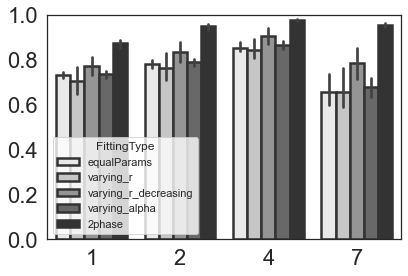

In [27]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.barplot(x="Delay",y="rSquared",hue="FittingType",
            edgecolor=".2", linewidth=2.5,
            palette="Greys",
            data=benchmarkingResultsDf, ax=ax)
# ax.tick_params(labelsize=42)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(0,1)
# ax.set_xticks([])
plt.tight_layout()
# plt.savefig("./figures/%s_different_n_steps_equalParams_%s.pdf"%(measure,cellLine))